# Chest X-Ray Medical Diagnosis with Deep Learning

In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/chest-x-ray-diagnosis'

## Imports

In [2]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

E0000 00:00:1741077882.711261   11339 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741077882.715425   11339 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

In [5]:
%matplotlib inline

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [6]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TEST_IMAGE_DIR)

datasets/images-small


In [7]:
IMAGE_DIR = Path('datasets/images-small')
TRAIN_CSV = Path('datasets/train-small.csv')
VALID_CSV = Path(cfg.DATASET_DIRS.VALID_CSV)
TEST_CSV = Path(cfg.DATASET_DIRS.TEST_CSV)

IMAGE_SIZE = cfg.TRAIN.IMG_SIZE

## Load the Datasets
[ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.

### Loading the Data

In [8]:
train_df = pd.read_csv(f"{TRAIN_CSV}")
valid_df = pd.read_csv(f"{VALID_CSV}")

test_df = pd.read_csv(f"{TEST_CSV}")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               1000 non-null   object
 1   Atelectasis         1000 non-null   int64 
 2   Cardiomegaly        1000 non-null   int64 
 3   Consolidation       1000 non-null   int64 
 4   Edema               1000 non-null   int64 
 5   Effusion            1000 non-null   int64 
 6   Emphysema           1000 non-null   int64 
 7   Fibrosis            1000 non-null   int64 
 8   Hernia              1000 non-null   int64 
 9   Infiltration        1000 non-null   int64 
 10  Mass                1000 non-null   int64 
 11  Nodule              1000 non-null   int64 
 12  PatientId           1000 non-null   int64 
 13  Pleural_Thickening  1000 non-null   int64 
 14  Pneumonia           1000 non-null   int64 
 15  Pneumothorax        1000 non-null   int64 
dtypes: int64(15), object(1)
m

In [10]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               200 non-null    object
 1   Atelectasis         200 non-null    int64 
 2   Cardiomegaly        200 non-null    int64 
 3   Consolidation       200 non-null    int64 
 4   Edema               200 non-null    int64 
 5   Effusion            200 non-null    int64 
 6   Emphysema           200 non-null    int64 
 7   Fibrosis            200 non-null    int64 
 8   Hernia              200 non-null    int64 
 9   Infiltration        200 non-null    int64 
 10  Mass                200 non-null    int64 
 11  Nodule              200 non-null    int64 
 12  PatientId           200 non-null    int64 
 13  Pleural_Thickening  200 non-null    int64 
 14  Pneumonia           200 non-null    int64 
 15  Pneumothorax        200 non-null    int64 
dtypes: int64(15), object(1)
me

In [11]:
valid_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               420 non-null    object
 1   PatientId           420 non-null    int64 
 2   Cardiomegaly        420 non-null    int64 
 3   Emphysema           420 non-null    int64 
 4   Effusion            420 non-null    int64 
 5   Hernia              420 non-null    int64 
 6   Infiltration        420 non-null    int64 
 7   Mass                420 non-null    int64 
 8   Nodule              420 non-null    int64 
 9   Atelectasis         420 non-null    int64 
 10  Pneumothorax        420 non-null    int64 
 11  Pleural_Thickening  420 non-null    int64 
 12  Pneumonia           420 non-null    int64 
 13  Fibrosis            420 non-null    int64 
 14  Edema               420 non-null    int64 
 15  Consolidation       420 non-null    int64 
dtypes: int64(15), object(1)
me

### Total Labels

In [13]:
column_names = list(train_df.columns)
labels = column_names[1:]
labels.remove('PatientId')
labels, len(labels)

(['Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Effusion',
  'Emphysema',
  'Fibrosis',
  'Hernia',
  'Infiltration',
  'Mass',
  'Nodule',
  'Pleural_Thickening',
  'Pneumonia',
  'Pneumothorax'],
 14)

In [14]:
train_df_labels = train_df[labels]
train_df_labels.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### Unique Check

In [15]:
train_df.PatientId.count(),train_df.PatientId.nunique()

(np.int64(1000), 928)

### Dataset Inbalance Check

In [16]:
sorted_df = train_df[labels].sum().sort_values()
sorted_df

Hernia                  2
Pneumonia              10
Emphysema              13
Fibrosis               14
Edema                  16
Cardiomegaly           20
Pleural_Thickening     21
Consolidation          33
Pneumothorax           38
Mass                   45
Nodule                 54
Atelectasis           106
Effusion              128
Infiltration          175
dtype: int64

In [17]:
sorted_df.values

array([  2,  10,  13,  14,  16,  20,  21,  33,  38,  45,  54, 106, 128,
       175])

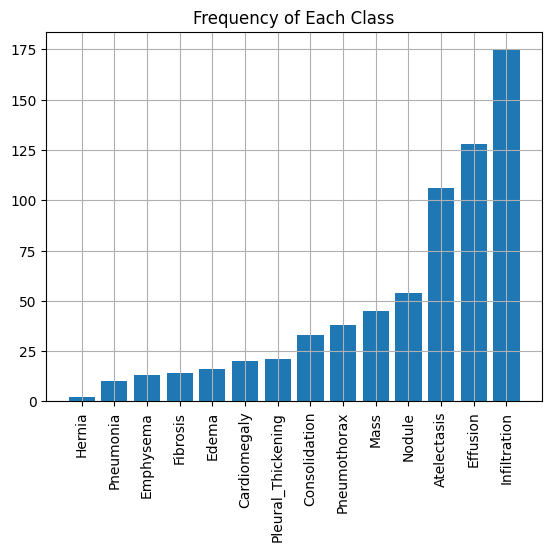

In [18]:
plt.xticks(rotation=90)
plt.bar(x=sorted_df.index, height=(sorted_df.values))
plt.title("Frequency of Each Class")
plt.grid()
plt.show()

## Data Visualization

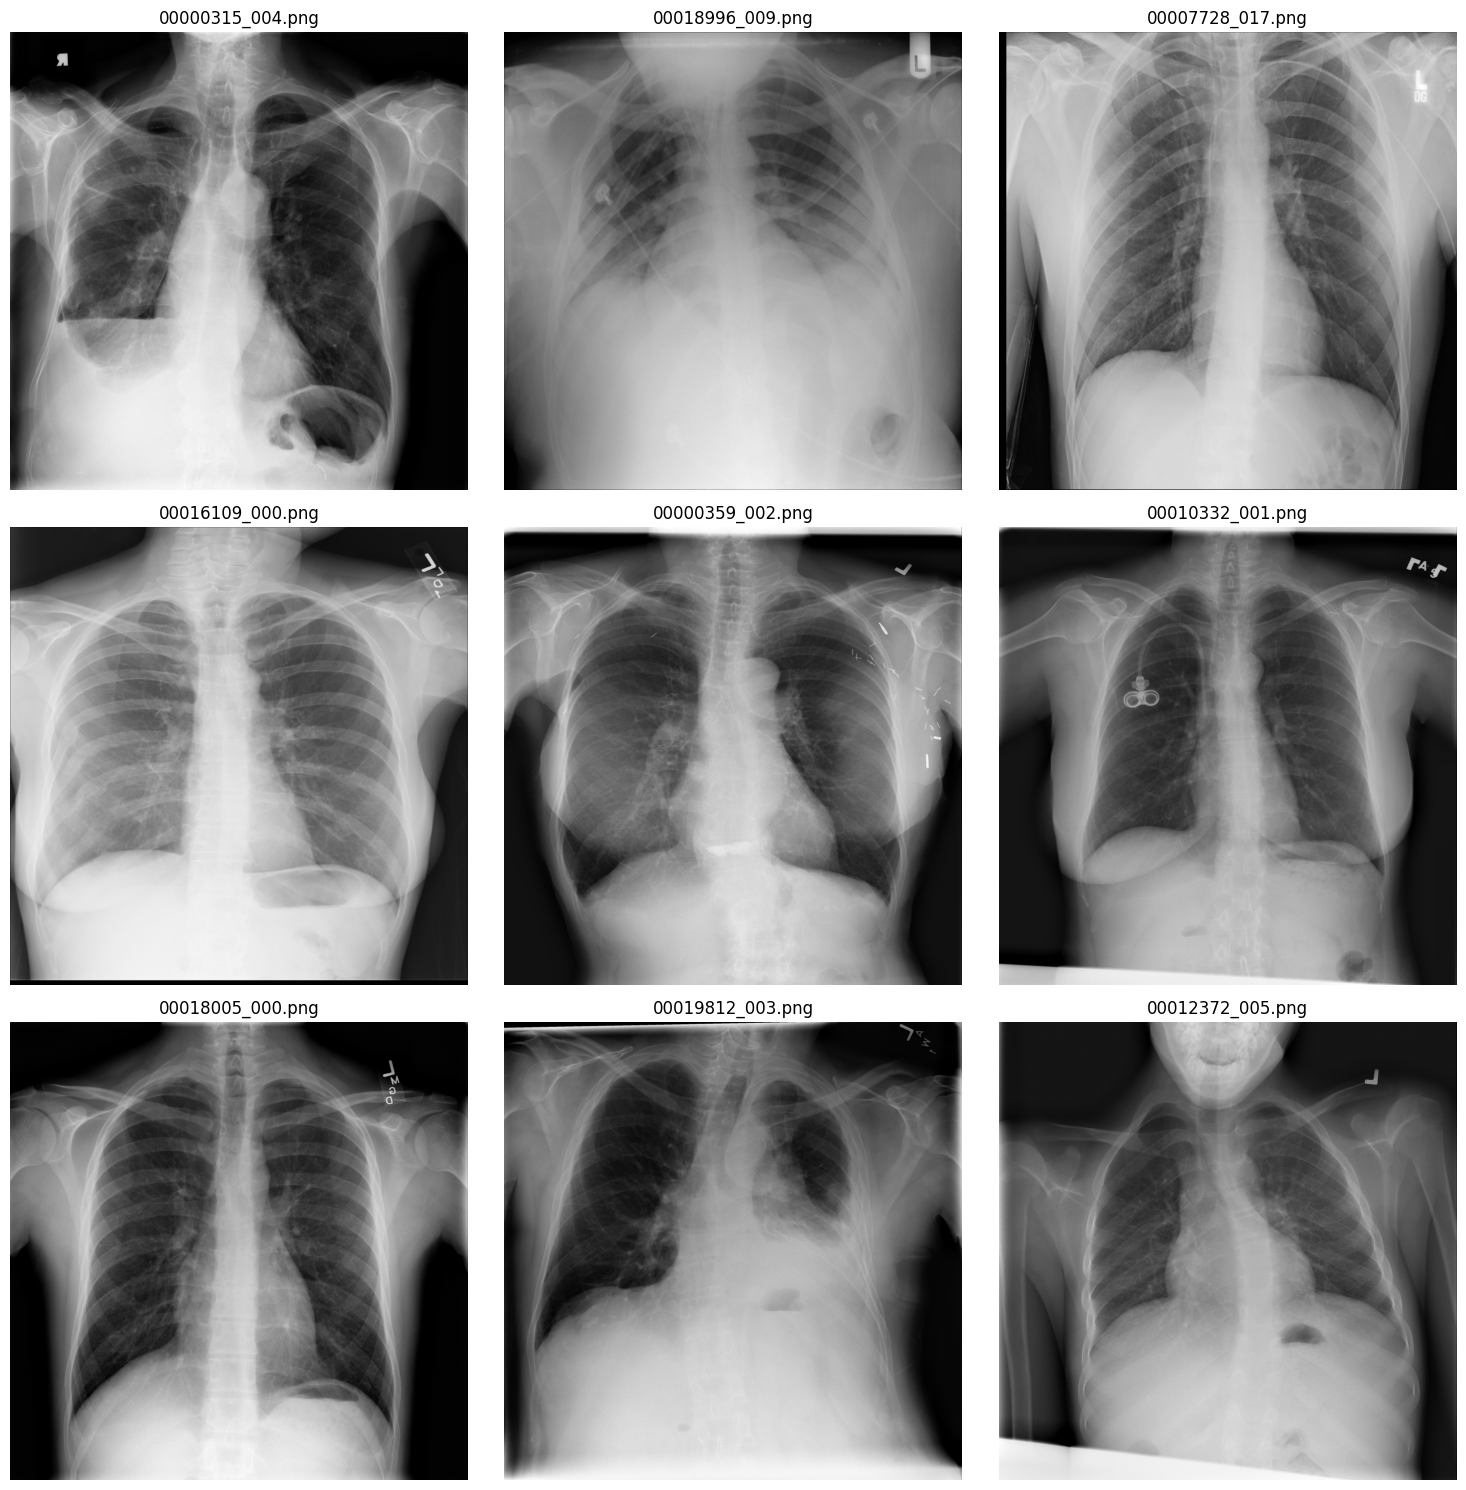

In [19]:
images = train_df.Image.values
IMAGE_NUM = 9
random_images = [np.random.choice(images) for _ in range(IMAGE_NUM)]

plt.figure(figsize=(15, 15))

for i in range(IMAGE_NUM):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(f"{cfg.DATASET_DIRS.TEST_IMAGE_DIR}/{random_images[i]}")
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title(random_images[i])
    
plt.tight_layout()
plt.show()

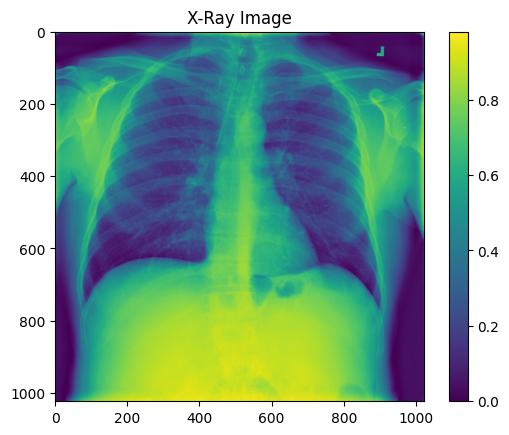

In [20]:
sample_image = train_df.Image[0]
img = plt.imread(f"{cfg.DATASET_DIRS.TEST_IMAGE_DIR}/{sample_image}")
plt.imshow(img)
plt.title('X-Ray Image')
plt.colorbar()

In [21]:
img.min(),img.max(), img.mean(),img.std()

(np.float32(0.0),
 np.float32(0.98039216),
 np.float32(0.47961414),
 np.float32(0.275735))

### Investigating Pixel Value Distribution

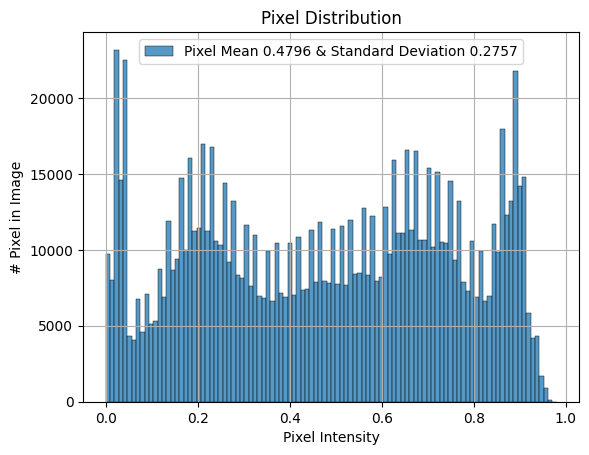

In [22]:
sns.histplot(img.ravel(),
    label=f'Pixel Mean {np.mean(img):.4f} & Standard Deviation {np.std(img):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Pixel Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel in Image')
plt.grid()

In [23]:
def load_image(image_name, label):
    full_path = tf.strings.join([f'{IMAGE_DIR}/', image_name])
    image = tf.io.read_file(full_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])  # Resize to the desired size
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_df.Image.values,  train_df_labels.values))
train_ds = train_ds.map(load_image)

I0000 00:00:1741077888.557009   11339 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1161 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [24]:
for batch in train_ds.take(1):
    image, label = batch
    print(image, label)

tf.Tensor(
[[[203.48     203.48     203.48    ]
  [194.97     194.97     194.97    ]
  [184.2      184.2      184.2     ]
  ...
  [192.       192.       192.      ]
  [200.63004  200.63004  200.63004 ]
  [212.6003   212.6003   212.6003  ]]

 [[144.91     144.91     144.91    ]
  [120.09     120.09     120.09    ]
  [101.35     101.35     101.35    ]
  ...
  [173.45     173.45     173.45    ]
  [188.31     188.31     188.31    ]
  [201.90022  201.90022  201.90022 ]]

 [[ 86.350006  86.350006  86.350006]
  [ 59.35      59.35      59.35    ]
  [ 41.5       41.5       41.5     ]
  ...
  [126.5      126.5      126.5     ]
  [173.50012  173.50012  173.50012 ]
  [191.2002   191.2002   191.2002  ]]

 ...

 [[ 13.45      13.45      13.45    ]
  [ 10.049999  10.049999  10.049999]
  [  8.         8.         8.      ]
  ...
  [ 13.75      13.75      13.75    ]
  [ 19.25003   19.25003   19.25003 ]
  [ 30.300049  30.300049  30.300049]]

 [[ 14.929998  14.929998  14.929998]
  [ 11.190008  11.190008  

In [25]:
import keras
normalization_layer = keras.layers.Normalization()


images_for_stats =  tf.concat([images for images, _ in train_ds.take(int(len(train_df) *0.25))], axis=0) 
normalization_layer.adapt(images_for_stats)

In [27]:

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
norm_img = None
for batch in train_ds.take(1):
    image, label = batch
    norm_img = image.numpy()
    print(norm_img.min(), norm_img.max(), norm_img.mean(),norm_img.std())

-1.9661821 1.9276925 -0.039099153 1.1072702


Generated Image: mean -0.0391 - Standard Deviation 1.1073 
Min pixel value -1.966 - Max pixel value 1.928


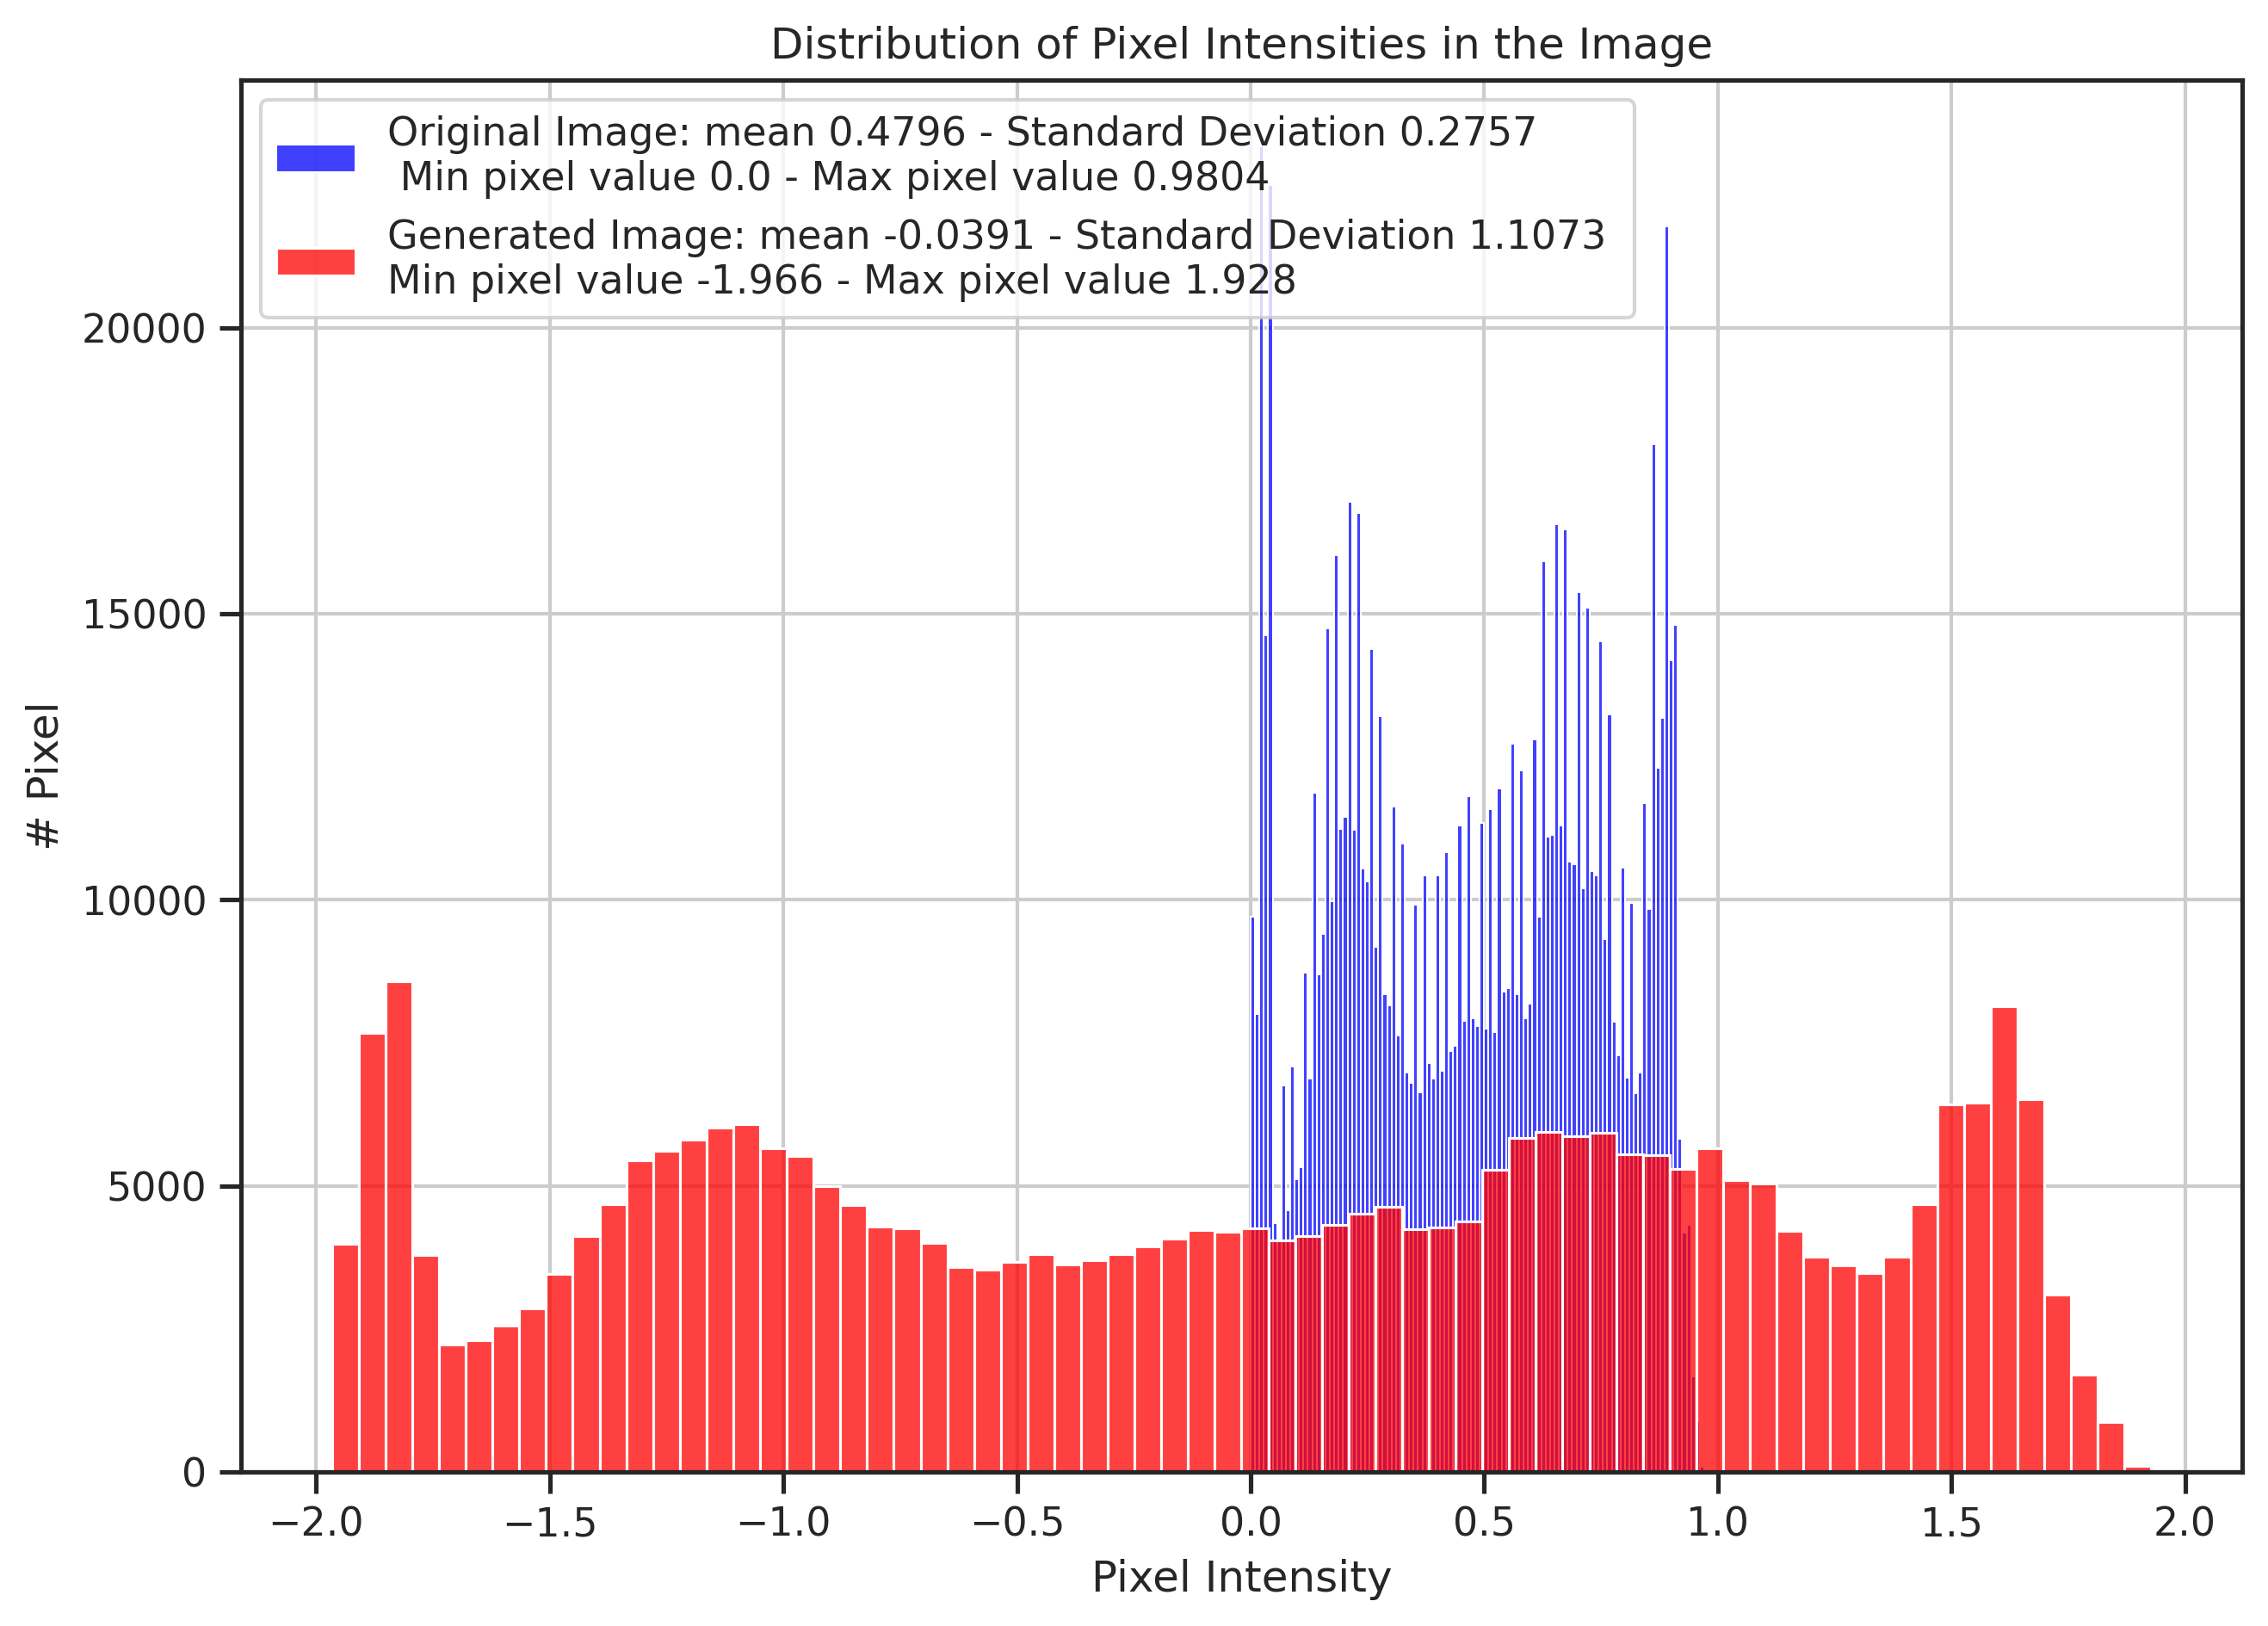

In [28]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
plt.figure(figsize=(10, 7))

sns.histplot(img.ravel(), 
             label=f'Original Image: mean {np.mean(img):.4f} - Standard Deviation {np.std(img):.4f} \n '
             f'Min pixel value {np.min(img):.4} - Max pixel value {np.max(img):.4}',
             color='blue', 
             kde=False)

# Plot histogram for generated image
sns.histplot(norm_img.ravel(), 
             label=f'Generated Image: mean {np.mean(norm_img):.4f} - Standard Deviation {np.std(norm_img):.4f} \n'
             f'Min pixel value {np.min(norm_img):.4} - Max pixel value {np.max(norm_img):.4}', 
             color='red', 
             kde=False)

plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')
plt.grid()
print(f'Generated Image: mean {np.mean(norm_img):.4f} - Standard Deviation {np.std(norm_img):.4f} \n'
             f'Min pixel value {np.min(norm_img):.4} - Max pixel value {np.max(norm_img):.4}')